## Title

Background

Question 
We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Can played hours and age of players predict the gender and experience of the players?

Data description

A csv file called `players.csv` is used which contains data of all unique Minecraft players including the following variables:

- `experience`:
- `subscribe`:
- `hashedEmail`:
- `played_hours`:
- `name`:
- `gender`:
- `Age`:
(add data type as well)

There are total of 196 observations and 7 variables.

summary stats

issues: experience and gender should be factor type so that the data can be classified, `hashedEmail` variable is unnecessary - it brings more confusion

how the data was collected?

In [50]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidyclust)
library(tidymodels)
library(recipes)

set.seed(5)

In [51]:
players <- read_csv("data/players.csv")

# preview of the data file players
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [52]:
# data wrangling

players_clean <- players |>
                select(-subscribe, -hashedEmail, -name) |>
                filter(played_hours != is.na(played_hours) & Age != is.na(Age)) |>
                filter(gender == "Male" | gender == "Female") |>
                mutate(experience = as_factor(experience)) |>
                mutate(gender = as_factor(gender))

head(players_clean)

experience,played_hours,gender,Age
<fct>,<dbl>,<fct>,<dbl>
Pro,30.3,Male,9
Veteran,3.8,Male,17
Amateur,0.7,Female,21
Regular,0.1,Male,21
Amateur,0.1,Male,17
Veteran,1.6,Female,23


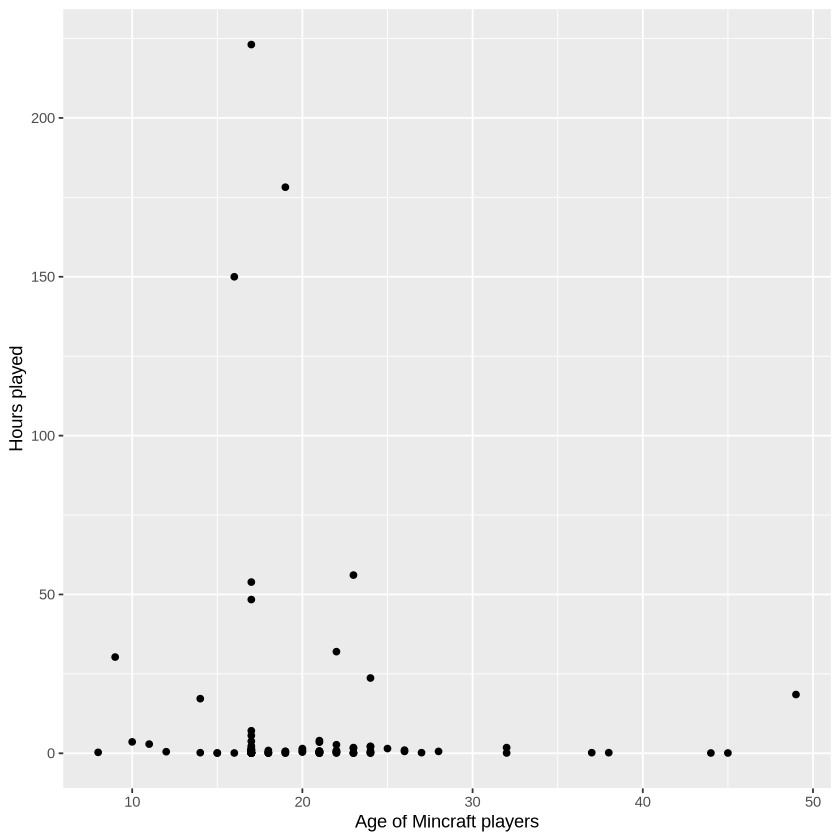

In [53]:
# age vs played_hours and color with gender, experience, subscribe separately.
hours_vs_age <- players_clean |>
            ggplot(aes(x = Age, y = played_hours)) +
            geom_point() + 
            xlab("Age of Mincraft players") +
            ylab("Hours played") 


hours_vs_age

According to the scatter plot above, it is necessary to scale the axes.

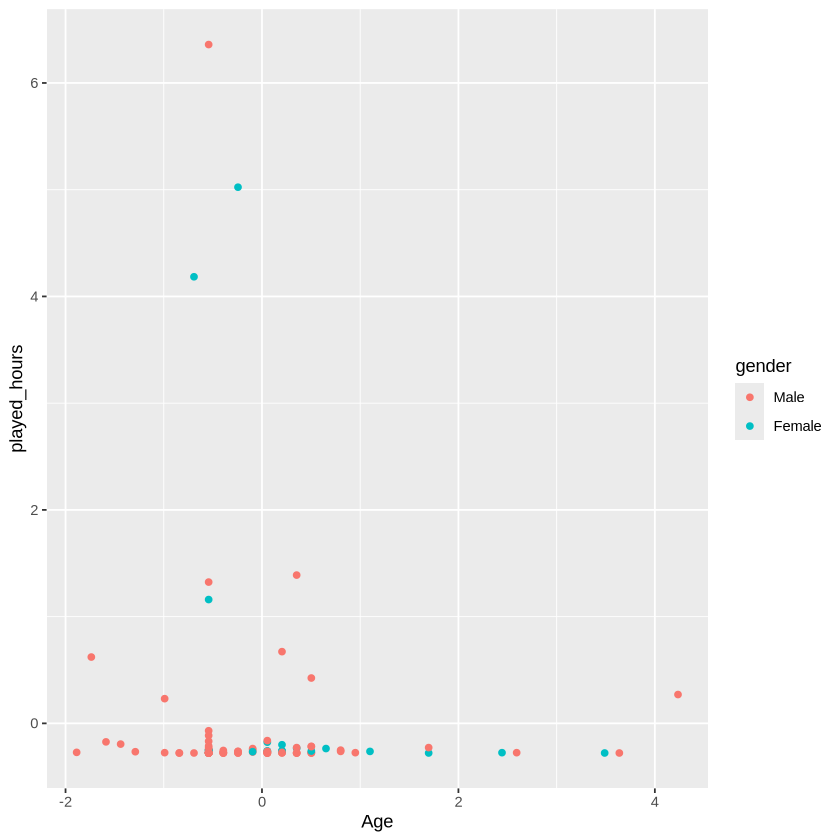

In [62]:
std_recipe <- recipe(gender ~ played_hours + Age, data = players_clean) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors()) |>
                prep()

players_scaled <- bake(std_recipe, players_clean)

players_plot_scaled <- ggplot(players_scaled,
                              aes(x = Age, y = played_hours, color = gender)) +
                        geom_point()
players_plot_scaled

In [54]:
# split data
players_split <- initial_split(players_clean, prop = 0.75, strata = gender)
players_train <- training(players_split) 
players_test <- testing(players_split)

# recipe
knn_recipe <- recipe(gender ~ played_hours + Age, data = players_clean) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

# choosing num of k 
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = gender)

knn_results <- workflow() |>
                add_recipe(knn_recipe) |>
                add_model(knn_spec_tune) |>
                tune_grid(resamples = players_vfold, grid = k_vals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6190476,5,0.049372479,Preprocessor1_Model01
3,accuracy,binary,0.6895238,5,0.049151531,Preprocessor1_Model02
5,accuracy,binary,0.7323810,5,0.041496933,Preprocessor1_Model03
7,accuracy,binary,0.7180952,5,0.022906692,Preprocessor1_Model04
9,accuracy,binary,0.7457143,5,0.029760952,Preprocessor1_Model05
11,accuracy,binary,0.7876190,5,0.024121762,Preprocessor1_Model06
13,accuracy,binary,0.7752381,5,0.010476190,Preprocessor1_Model07
15,accuracy,binary,0.7752381,5,0.010476190,Preprocessor1_Model08
17,accuracy,binary,0.7885714,5,0.002857143,Preprocessor1_Model09


In [55]:
kmax <- knn_results |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

kmax

[1] 17

In [57]:
# redefine model spec and fitting using the K chosen

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmax) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(knn_spec) |>
            fit(players_train)

players_predict <- knn_fit |>
                predict(players_test)

players_predict

.pred_class
<fct>
Male
Male
Male
Male
Male
Male
Male
Male
Male
